In [261]:
import pandas as pd
import json
import datetime as dt
import numpy as np
# !pip install matplotlib
# !pip install lightgbm

## Load Data

In [262]:
def get_one_hot(df, feature):
    one_hot = pd.get_dummies(df[feature])
    one_hot.columns = [feature+'_'+str(i.lower().translate(str.maketrans('áéíóúü','aeiouu'))) for i in one_hot.columns]
    return one_hot

In [263]:
with open('../data/train.json', mode='r') as f:
    data = json.load(f)
list_dict_data = []
for i in data:
    dict_data = {}
    for j in i:
        dict_data[list(j.keys())[0]] = j[list(j.keys())[0]]
    list_dict_data.append(dict_data)
train = pd.DataFrame(list_dict_data)
train.columns = [i.lower().translate(str.maketrans('áéíóúü','aeiouu')) for i in list(train.columns)]
# train['nombre_campania'] = train['nombre_campania'].replace({'GASTRONOMIA':'GASTRONOMY','GASTRONOMÃ�A':'GASTRONOMY'})
train['nombre_campania'] = train['nombre_campania'].replace({'GASTRONOMIA':'GASTRONOMY','GASTRONOMÃ�A':'GASTRONOMY','GASTRONOMÍA':'GASTRONOMY'})

train.drop(['moneda', 'country', 'brand'], axis=1, inplace=True)
train['fecha_publicacion_anuncio'] = train['fecha_publicacion_anuncio'].apply(lambda x: dt.datetime.strptime(x, '%a, %d %b %Y 00:00:00 GMT') if x else np.nan)
train['fecha_captura_informacion'] = train['fecha_captura_informacion'].apply(lambda x: dt.datetime.strptime(x, '%a, %d %b %Y 00:00:00 GMT') if x else np.nan)
train['interacciones'] = train['interacciones'].astype('int32')
train['duracion_anuncio_total'] = (train['fecha_captura_informacion'] - train['fecha_publicacion_anuncio']).dt.days

train2 = train[['fecha_captura_informacion','fecha_publicacion_anuncio']]
train2 = train2[train2['fecha_publicacion_anuncio'].notna()]
train3 = train2.groupby(['fecha_captura_informacion'], dropna=True).apply(pd.DataFrame.mode).reset_index(drop=True)


##CREANDO CAMPO DIFF DIAS JLP
train = train.sort_values(['id_anuncio','fecha_captura_informacion'], ascending = True)
grouped = train.groupby('id_anuncio')
diff = lambda x: x['fecha_captura_informacion'].replace(0, np.NaN).diff() 
train["DIFF"] = grouped.apply(diff).reset_index(0, drop = True).dt.days
train['DIFF'].fillna(train['duracion_anuncio_total'], inplace = True)


train.drop(['fecha_publicacion_anuncio', 'fecha_captura_informacion'], axis=1, inplace=True) ## OJO
# train.drop(['id_anuncio','id_conjunto_anuncios','id_campania'], axis=1, inplace=True) ## OJO
train = train.set_index('id_observacion')
## aplicar la variable compuesta a id_anuncion y  captura de info
# var_cuanti = ['duracion_anuncio', 'gasto', 'visitas_al_50', 'visitas_al_75', 'visitas_al100','impresiones','DIFF']
var_categ = ['fuente','objetivo_campania','formato','nombre_campania']

list_df = []
for i in var_categ:
    df = get_one_hot(train, i)
    list_df.append(df)
train_categ = pd.concat(list_df,axis=1)

train_final = train.join(train_categ)
train_final.drop(var_categ, axis=1, inplace=True) ### OJO
Y = train_final['interacciones']
train_final.drop(['interacciones'], axis=1, inplace=True)
train_final

,id_anuncio,id_conjunto_anuncios,id_campania,gasto,visitas_al_50,visitas_al_75,visitas_al100,impresiones,duracion_anuncio_total,DIFF,...,formato_video,nombre_campania_aon,nombre_campania_cusquena,nombre_campania_equity,nombre_campania_fin de ano,nombre_campania_gastronomia promo,nombre_campania_gastronomy,nombre_campania_promo cusquena,nombre_campania_terra cusco,nombre_campania_terra lima
id_observacion,,,,,,,,,,,,,,,,,,,,,
ID_000129,"1,136,292,264,672,720,000",i25608626,i21206311,437.500000,56939.0,42590.0,34748.0,1.139250e+05,3.0,3.0,...,1,1,0,0,0,0,0,0,0,0
ID_000126,"1,138,211,077,668,450,000",i25666138,i21241415,250.000000,51455.0,42138.0,38094.0,7.094100e+04,0.0,0.0,...,1,1,0,0,0,0,0,0,0,0
ID_000127,"1,138,211,077,668,450,000",i25666138,i21241415,250.000000,51380.0,41780.0,37794.0,7.208100e+04,1.0,1.0,...,1,1,0,0,0,0,0,0,0,0
ID_000128,"1,138,211,077,668,450,000",i25666138,i21241415,250.000000,50290.0,40958.0,36977.0,7.106100e+04,2.0,1.0,...,1,1,0,0,0,0,0,0,0,0
ID_000125,"1,138,211,077,668,450,000",i25666138,i21241415,250.000000,52213.0,42609.0,38686.0,7.240000e+04,3.0,1.0,...,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ID_005561,None,None,None,461.538461,NaN,NaN,NaN,6.593407e+04,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0
ID_005446,None,None,None,272.500000,NaN,NaN,NaN,1.362500e+05,NaN,NaN,...,0,1,0,0,0,0,0,0,0,0
ID_005487,None,None,None,1576.923077,NaN,NaN,NaN,1.051282e+06,NaN,NaN,...,0,1,0,0,0,0,0,0,0,0


In [264]:
train_final.isna().sum()

id_anuncio                           2389
id_conjunto_anuncios                 2389
id_campania                          2389
gasto                                   0
visitas_al_50                        1015
visitas_al_75                        1015
visitas_al100                        1015
impresiones                             0
duracion_anuncio_total               2389
DIFF                                 2389
fuente_direct                           0
fuente_fb + ig                          0
fuente_facebook                         0
fuente_instagram                        0
fuente_oath                             0
fuente_search                           0
fuente_teads                            0
fuente_twitter                          0
fuente_youtube                          0
objetivo_campania_brand awareness       0
objetivo_campania_conversions           0
objetivo_campania_engagement            0
objetivo_campania_event responses       0
objetivo_campania_reach           

In [265]:
# validation = pd.read_csv('../data/Data_Validacion.csv',sep=';')
validation = pd.read_csv('../data/Data_Validacion.csv',sep=';')
index_val = validation.index
validation.columns = [i.lower().translate(str.maketrans('áéíóúü','aeiouu')) for i in list(validation.columns)]
# train['nombre_campania'] = train['nombre_campania'].replace({'GASTRONOMIA':'GASTRONOMY','GASTRONOMÃ�A':'GASTRONOMY'})
validation['nombre_campania'] = validation['nombre_campania'].replace({'GASTRONOMIA':'GASTRONOMY','GASTRONOMÃ�A':'GASTRONOMY','GASTRONOMÍA':'GASTRONOMY'})

validation.drop(['moneda', 'country', 'brand'], axis=1, inplace=True)
validation['fecha_publicacion_anuncio'] = validation['fecha_publicacion_anuncio'].apply(lambda x: dt.datetime.strptime(x, '%a, %d %b %Y 00:00:00 GMT') if str(x)!='nan' else np.nan)
validation['fecha_captura_informacion'] = validation['fecha_captura_informacion'].apply(lambda x: dt.datetime.strptime(x, '%a, %d %b %Y 00:00:00 GMT') if str(x)!='nan' else np.nan)
validation['duracion_anuncio_total'] = (validation['fecha_captura_informacion'] - validation['fecha_publicacion_anuncio']).dt.days

##CREANDO CAMPO DIFF DIAS JLP
validation = validation.sort_values(['id_anuncio','fecha_captura_informacion'], ascending = True)
grouped = validation.groupby('id_anuncio')
diff = lambda x: x['fecha_captura_informacion'].replace(0, np.NaN).diff() 
validation["DIFF"] = grouped.apply(diff).reset_index(0, drop = True).dt.days
validation['DIFF'].fillna(validation['duracion_anuncio_total'], inplace = True)
##
validation.drop(['fecha_publicacion_anuncio', 'fecha_captura_informacion'], axis=1, inplace=True)
validation.drop(['id_anuncio','id_conjunto_anuncios','id_campania'], axis=1, inplace=True)
## aplicar la variable compuesta a id_anuncion y  captura de info
# var_cuanti = ['duracion_anuncio_total', 'gasto', 'visitas_al_50', 'visitas_al_75', 'visitas_al100','impresiones']
var_categ = ['fuente','objetivo_campania','formato','nombre_campania']
list_df = []
for i in var_categ:
    df = get_one_hot(validation, i)
    list_df.append(df)
validation_categ = pd.concat(list_df,axis=1)

validation_final = validation.join(validation_categ)
validation_final.drop(var_categ, axis=1, inplace=True)
validation_final = validation_final.set_index('id_observacion')
validation_final['gasto'] = validation_final['gasto'].replace({'40000%':40000})
validation_final['gasto'] = validation_final['gasto'].astype(float)
validation_final

,gasto,visitas_al_50,visitas_al_75,visitas_al100,impresiones,duracion_anuncio_total,DIFF,fuente_direct,fuente_fb + ig,fuente_facebook,...,nombre_campania_aon,nombre_campania_aon,nombre_campania_cusquena,nombre_campania_equity,nombre_campania_fin de ano,nombre_campania_gastronomia promo,nombre_campania_gastronomy,nombre_campania_promo cusquena,nombre_campania_terra cusco,nombre_campania_terra lima
id_observacion,,,,,,,,,,,,,,,,,,,,,
ID_V_001302,49.843780,0.0,0.0,0.0,10250.00000,0.0,0.0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
ID_V_001303,243.361200,42211.0,41183.0,40066.0,45521.00000,2.0,2.0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
ID_V_001317,210.701380,35514.0,34674.0,33773.0,37989.00000,3.0,1.0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
ID_V_001298,75.990030,13436.0,13075.0,12674.0,14713.00000,4.0,1.0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
ID_V_001304,176.074470,28822.0,28091.0,27341.0,31268.00000,5.0,1.0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ID_V_002376,461.538461,NaN,NaN,NaN,65934.06593,NaN,NaN,0,0,0,...,0,0,0,0,0,0,1,0,0,0
ID_V_002322,272.500000,NaN,NaN,NaN,136250.00000,NaN,NaN,0,0,0,...,1,0,0,0,0,0,0,0,0,0
ID_V_002377,461.538461,NaN,NaN,NaN,65934.06593,NaN,NaN,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [272]:
# features = list(set(train_final.columns).intersection(set(validation_final.columns)))
features = list(feature_importances.index)
train_final = train_final[features]
validation_final = validation_final[features]

In [273]:
from sklearn.model_selection import train_test_split
x_train,x_test, y_train, y_test = train_test_split(train_final, Y, test_size=0.2, random_state = 42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((4449, 35), (1113, 35), (4449,), (1113,))

In [274]:
from lightgbm import LGBMRegressor
learner = LGBMRegressor(n_estimators=1000)
learner.fit(x_train, y_train,  early_stopping_rounds=10, eval_metric="mae",
                eval_set=[(x_train, y_train), (x_test, y_test)], verbose=50)

[50]	training's l1: 118.183	training's l2: 199584	valid_1's l1: 193.767	valid_1's l2: 1.38726e+06


C:\Users\usuario\anaconda3\envs\venv_backus\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\usuario\anaconda3\envs\venv_backus\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


LGBMRegressor(n_estimators=1000)

In [275]:
learner.fit(x_train, y_train, eval_metric="mae")

LGBMRegressor(n_estimators=1000)

In [276]:
validation_final['INTERACCIONES'] = learner.predict(validation_final)
validation_final

C:\Users\usuario\AppData\Local\Temp/ipykernel_14904/1123091501.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_final['INTERACCIONES'] = learner.predict(validation_final)


,gasto,impresiones,duracion_anuncio_total,visitas_al_75,visitas_al100,visitas_al_50,DIFF,nombre_campania_gastronomy,fuente_direct,formato_imagen,...,fuente_youtube,formato_video,formato_banner rm,nombre_campania_gastronomia promo,formato_key words,formato_rm display,objetivo_campania_event responses,fuente_search,formato_bumper ad,INTERACCIONES
id_observacion,,,,,,,,,,,,,,,,,,,,,
ID_V_001302,49.843780,10250.00000,0.0,0.0,0.0,0.0,0.0,1,0,0,...,0,1,0,0,0,0,0,0,0,175.346073
ID_V_001303,243.361200,45521.00000,2.0,41183.0,40066.0,42211.0,2.0,1,0,0,...,0,1,0,0,0,0,0,0,0,703.423374
ID_V_001317,210.701380,37989.00000,3.0,34674.0,33773.0,35514.0,1.0,1,0,0,...,0,1,0,0,0,0,0,0,0,178.438836
ID_V_001298,75.990030,14713.00000,4.0,13075.0,12674.0,13436.0,1.0,1,0,0,...,0,1,0,0,0,0,0,0,0,34.064577
ID_V_001304,176.074470,31268.00000,5.0,28091.0,27341.0,28822.0,1.0,1,0,0,...,0,1,0,0,0,0,0,0,0,-254.571948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ID_V_002376,461.538461,65934.06593,NaN,NaN,NaN,NaN,NaN,1,0,0,...,0,0,0,0,0,0,0,0,0,-1.886987
ID_V_002322,272.500000,136250.00000,NaN,NaN,NaN,NaN,NaN,0,0,0,...,1,0,0,0,0,0,0,0,0,-6.868963
ID_V_002377,461.538461,65934.06593,NaN,NaN,NaN,NaN,NaN,1,0,0,...,0,0,0,0,0,0,0,0,0,-1.886987


In [271]:
feature_importances = pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=train_final.columns).sort_values(ascending=False)
feature_importances = feature_importances[feature_importances>0]
len(feature_importances)

35

In [277]:
validation_final = validation_final.reset_index()
validation_final = validation_final[['id_observacion','INTERACCIONES']]
# ID_OBSERVACION, INTERACCIONES.
validation_final.columns = ['ID_OBSERVACION', 'INTERACCIONES']
validation_final

,ID_OBSERVACION,INTERACCIONES
0,ID_V_001302,175.346073
1,ID_V_001303,703.423374
2,ID_V_001317,178.438836
3,ID_V_001298,34.064577
4,ID_V_001304,-254.571948
...,...,...
2373,ID_V_002376,-1.886987
2374,ID_V_002322,-6.868963
2375,ID_V_002377,-1.886987
2376,ID_V_002378,-1.886987


In [278]:
mask = validation_final['INTERACCIONES']<=0
validation_final.loc[mask,'INTERACCIONES'] = 0

In [279]:
validation_final.to_csv('../results/test7.csv', index=False)

In [280]:
len(feature_importances)

35

In [281]:
feature_importances

gasto                                0.306933
impresiones                          0.247500
duracion_anuncio_total               0.140633
visitas_al_75                        0.060400
visitas_al100                        0.042333
visitas_al_50                        0.041733
DIFF                                 0.026667
nombre_campania_gastronomy           0.021333
fuente_direct                        0.014000
formato_imagen                       0.010567
objetivo_campania_traffic            0.010367
objetivo_campania_engagement         0.008433
nombre_campania_promo cusquena       0.007833
fuente_fb + ig                       0.007567
objetivo_campania_brand awareness    0.006600
objetivo_campania_video views        0.005900
objetivo_campania_conversions        0.005633
objetivo_campania_reach              0.005067
formato_carrusel                     0.004933
fuente_twitter                       0.004767
fuente_facebook                      0.004000
nombre_campania_aon               

<AxesSubplot:>

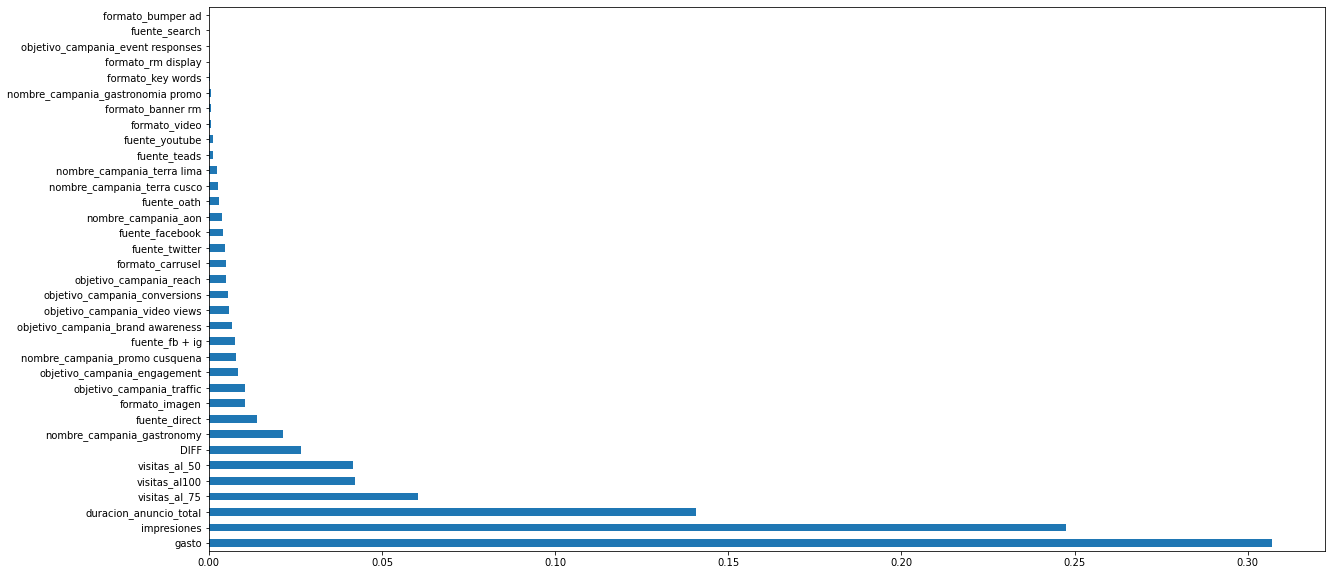

In [282]:
%matplotlib inline
feature_importances.nlargest(35).plot(kind='barh', figsize=(20,10))